In [1]:
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
import warnings
import json
warnings.filterwarnings('ignore')

In [2]:
filename = '/content/drive/MyDrive/datasets/tweets_all.csv'
with open(filename, 'r') as f:
    lines = f.readlines()
    tweets = [json.loads(line) for line in lines]

weibo = pd.DataFrame(tweets)
weibo.head()

_id    mblogid           created_at   geo ip_location  \
0  4456074101048675  InwK64oO7  2020-01-01 23:58:38  None        None   
1  4456346994385879  InDQfioXZ  2020-01-02 18:03:01  None        None   
2  4456708640152760  InNfy0DJS  2020-01-03 18:00:04  None        None   
3  4457137742579445  InYpEaP1X  2020-01-04 22:25:09  None        None   
4  4457463639793854  Io6ThF5Po  2020-01-05 20:00:09  None        None   

   reposts_count  comments_count  attitudes_count        source  \
0              0               0                1          微信读书   
1              3              12               19                 
2              0               0                0  微博 weibo.com   
3              0               1                0     iPhone客户端   
4              7              17               31                 

                                             content  ... isLongText  \
0                                     清军在新疆地区的种族灭绝。   ...      False   
1  【西雅图流浪汉怒吼“讨厌中国人”……然后痛殴了两名韩国游客】#新疆话唠哥# \n\n据美国中...  ...       True   
2  #外媒视界#【南非主流媒体：“近百万维吾尔人被拘押”不可信】\n　　近日，南非主流媒体《公民...  ...       True   
3  昨儿和MC“互诉衷肠”，互相打气未来别怂！\n\nMC是一个长得像羊肉串的姑娘，新疆味十足，...  ...       True   
4  【真准备对伊朗大打出手？美国征兵宣称没有上限，官方网站随即崩溃】#新疆话唠哥# \n\n20...  ...       True   

   is_retweet                                               user  \
0       False  {'_id': '1782037835', 'avatar_hd': 'https://tv...   
1       False  {'_id': '3016011261', 'avatar_hd': 'https://tv...   
2       False  {'_id': '2724540602', 'avatar_hd': 'https://tv...   
3       False  {'_id': '1804914184', 'avatar_hd': 'https://tv...   
4       False  {'_id': '3016011261', 'avatar_hd': 'https://tv...   

                                      url keyword  crawl_time reads_count  \
0  https://weibo.com/1782037835/InwK64oO7    新疆种族  1708718770         NaN   
1  https://weibo.com/3016011261/InDQfioXZ    新疆种族  1708718773         NaN   
2  https://weibo.com/2724540602/InNfy0DJS    新疆种族  1708718774      3883.0   
3  https://weibo.com/1804914184/InYpEaP1X    新疆种族  1708718775         NaN   
4  https://weibo.com/3016011261/Io6ThF5Po    新疆种族  1708718776         NaN   

   video  video_online_numbers retweet_id  
0    NaN                   NaN        NaN  
1    NaN                   NaN        NaN  
2    NaN                   NaN        NaN  
3    NaN                   NaN        NaN  
4    NaN                   NaN        NaN  

[5 rows x 22 columns]

In [3]:
weibo_retweet = weibo[weibo['is_retweet']]
len(weibo_retweet)

5953

In [6]:
!pip uninstall community
!pip uninstall python-louvain
!pip install python-louvain

Found existing installation: community 1.0.0b1
Uninstalling community-1.0.0b1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/community-1.0.0b1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/community/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/community/community_louvain.py
    /usr/local/lib/python3.10/dist-packages/community/community_status.py
Proceed (Y/n)? Y
  Successfully uninstalled community-1.0.0b1
Found existing installation: python-louvain 0.16
Uninstalling python-louvain-0.16:
  Would remove:
    /usr/local/bin/community
    /usr/local/lib/python3.10/dist-packages/community/community_louvain.py
    /usr/local/lib/python3.10/dist-packages/community/community_status.py
    /usr/local/lib/python3.10/dist-packages/python_louvain-0.16.dist-info/*
Proceed (Y/n)? Y
  Successfully uninstalled python-louvain-0.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadat

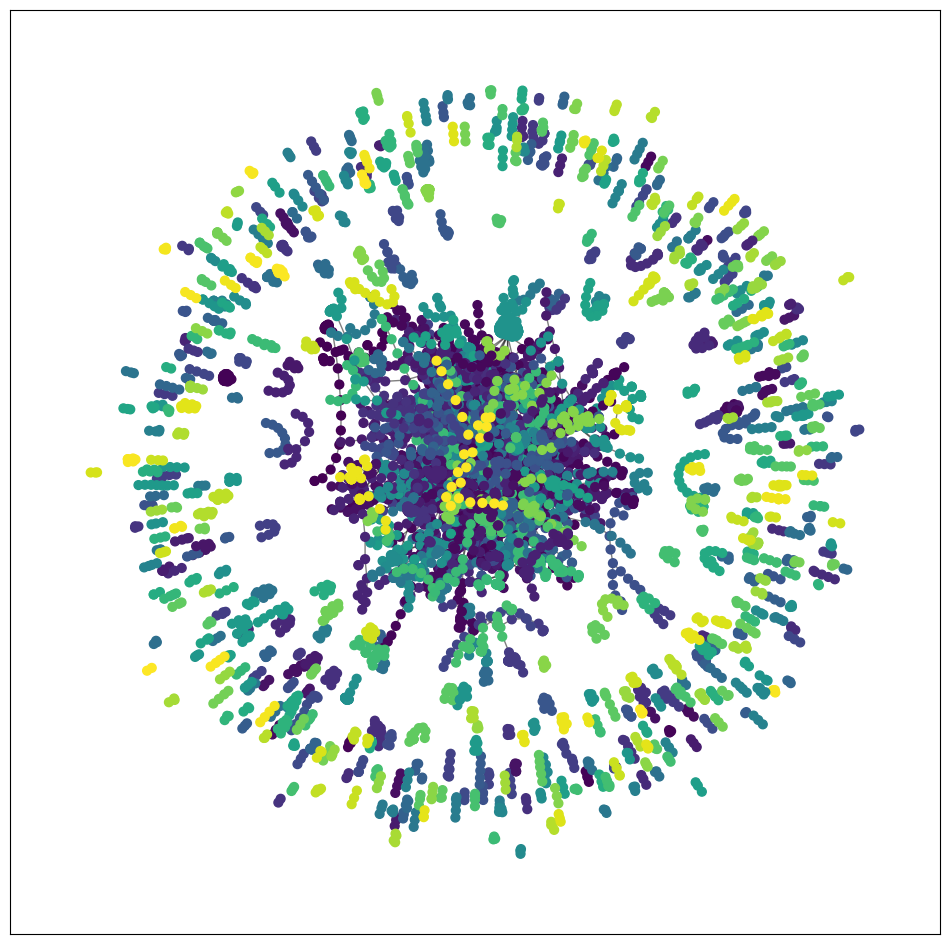

In [4]:
def extract_relations_and_link_to_root(text, root_id, user):
    users = re.findall(r'@([\w\W]+?):', text)
    relations = [(users[i], users[i+1]) for i in range(len(users)-1)]
    if users:
        relations.append((users[-1], root_id))
        relations.append((user['nick_name'], users[0]))
    return relations

G = nx.DiGraph()

for index, row in weibo_retweet.iterrows():
    relations = extract_relations_and_link_to_root(row['content'], row['retweet_id'], row['user'])
    for source, target in relations:
        if source != target:
          G.add_edge(source, target)

G = G.to_undirected()

partition = community_louvain.best_partition(G)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)

cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [ ]:
betweenness = nx.betweenness_centrality(G)
top_ten = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 nodes by betweenness centrality:")
for node, centrality in top_ten:
    print(f"Node: {node}, Betweenness Centrality: {centrality}")

Top 10 nodes by betweenness centrality:
Node: 神猫罗尼休, Betweenness Centrality: 0.07698986762893767
Node: Tiger公子, Betweenness Centrality: 0.0683823923168972
Node: 赵立坚个人微博, Betweenness Centrality: 0.06380136232178557
Node: 夏目家的小诗哥, Betweenness Centrality: 0.05949443218461786
Node: 日本傻事, Betweenness Centrality: 0.05425879789936669
Node: 伊谢尔伦的风, Betweenness Centrality: 0.05335209357184752
Node: 重工组长于彦舒, Betweenness Centrality: 0.04995831954338832
Node: 八鸡扒摁撕垃圾站, Betweenness Centrality: 0.047938606114465085
Node: JoannaBlue, Betweenness Centrality: 0.047819879659285
Node: 红烧蒸猪, Betweenness Centrality: 0.047068996074464936


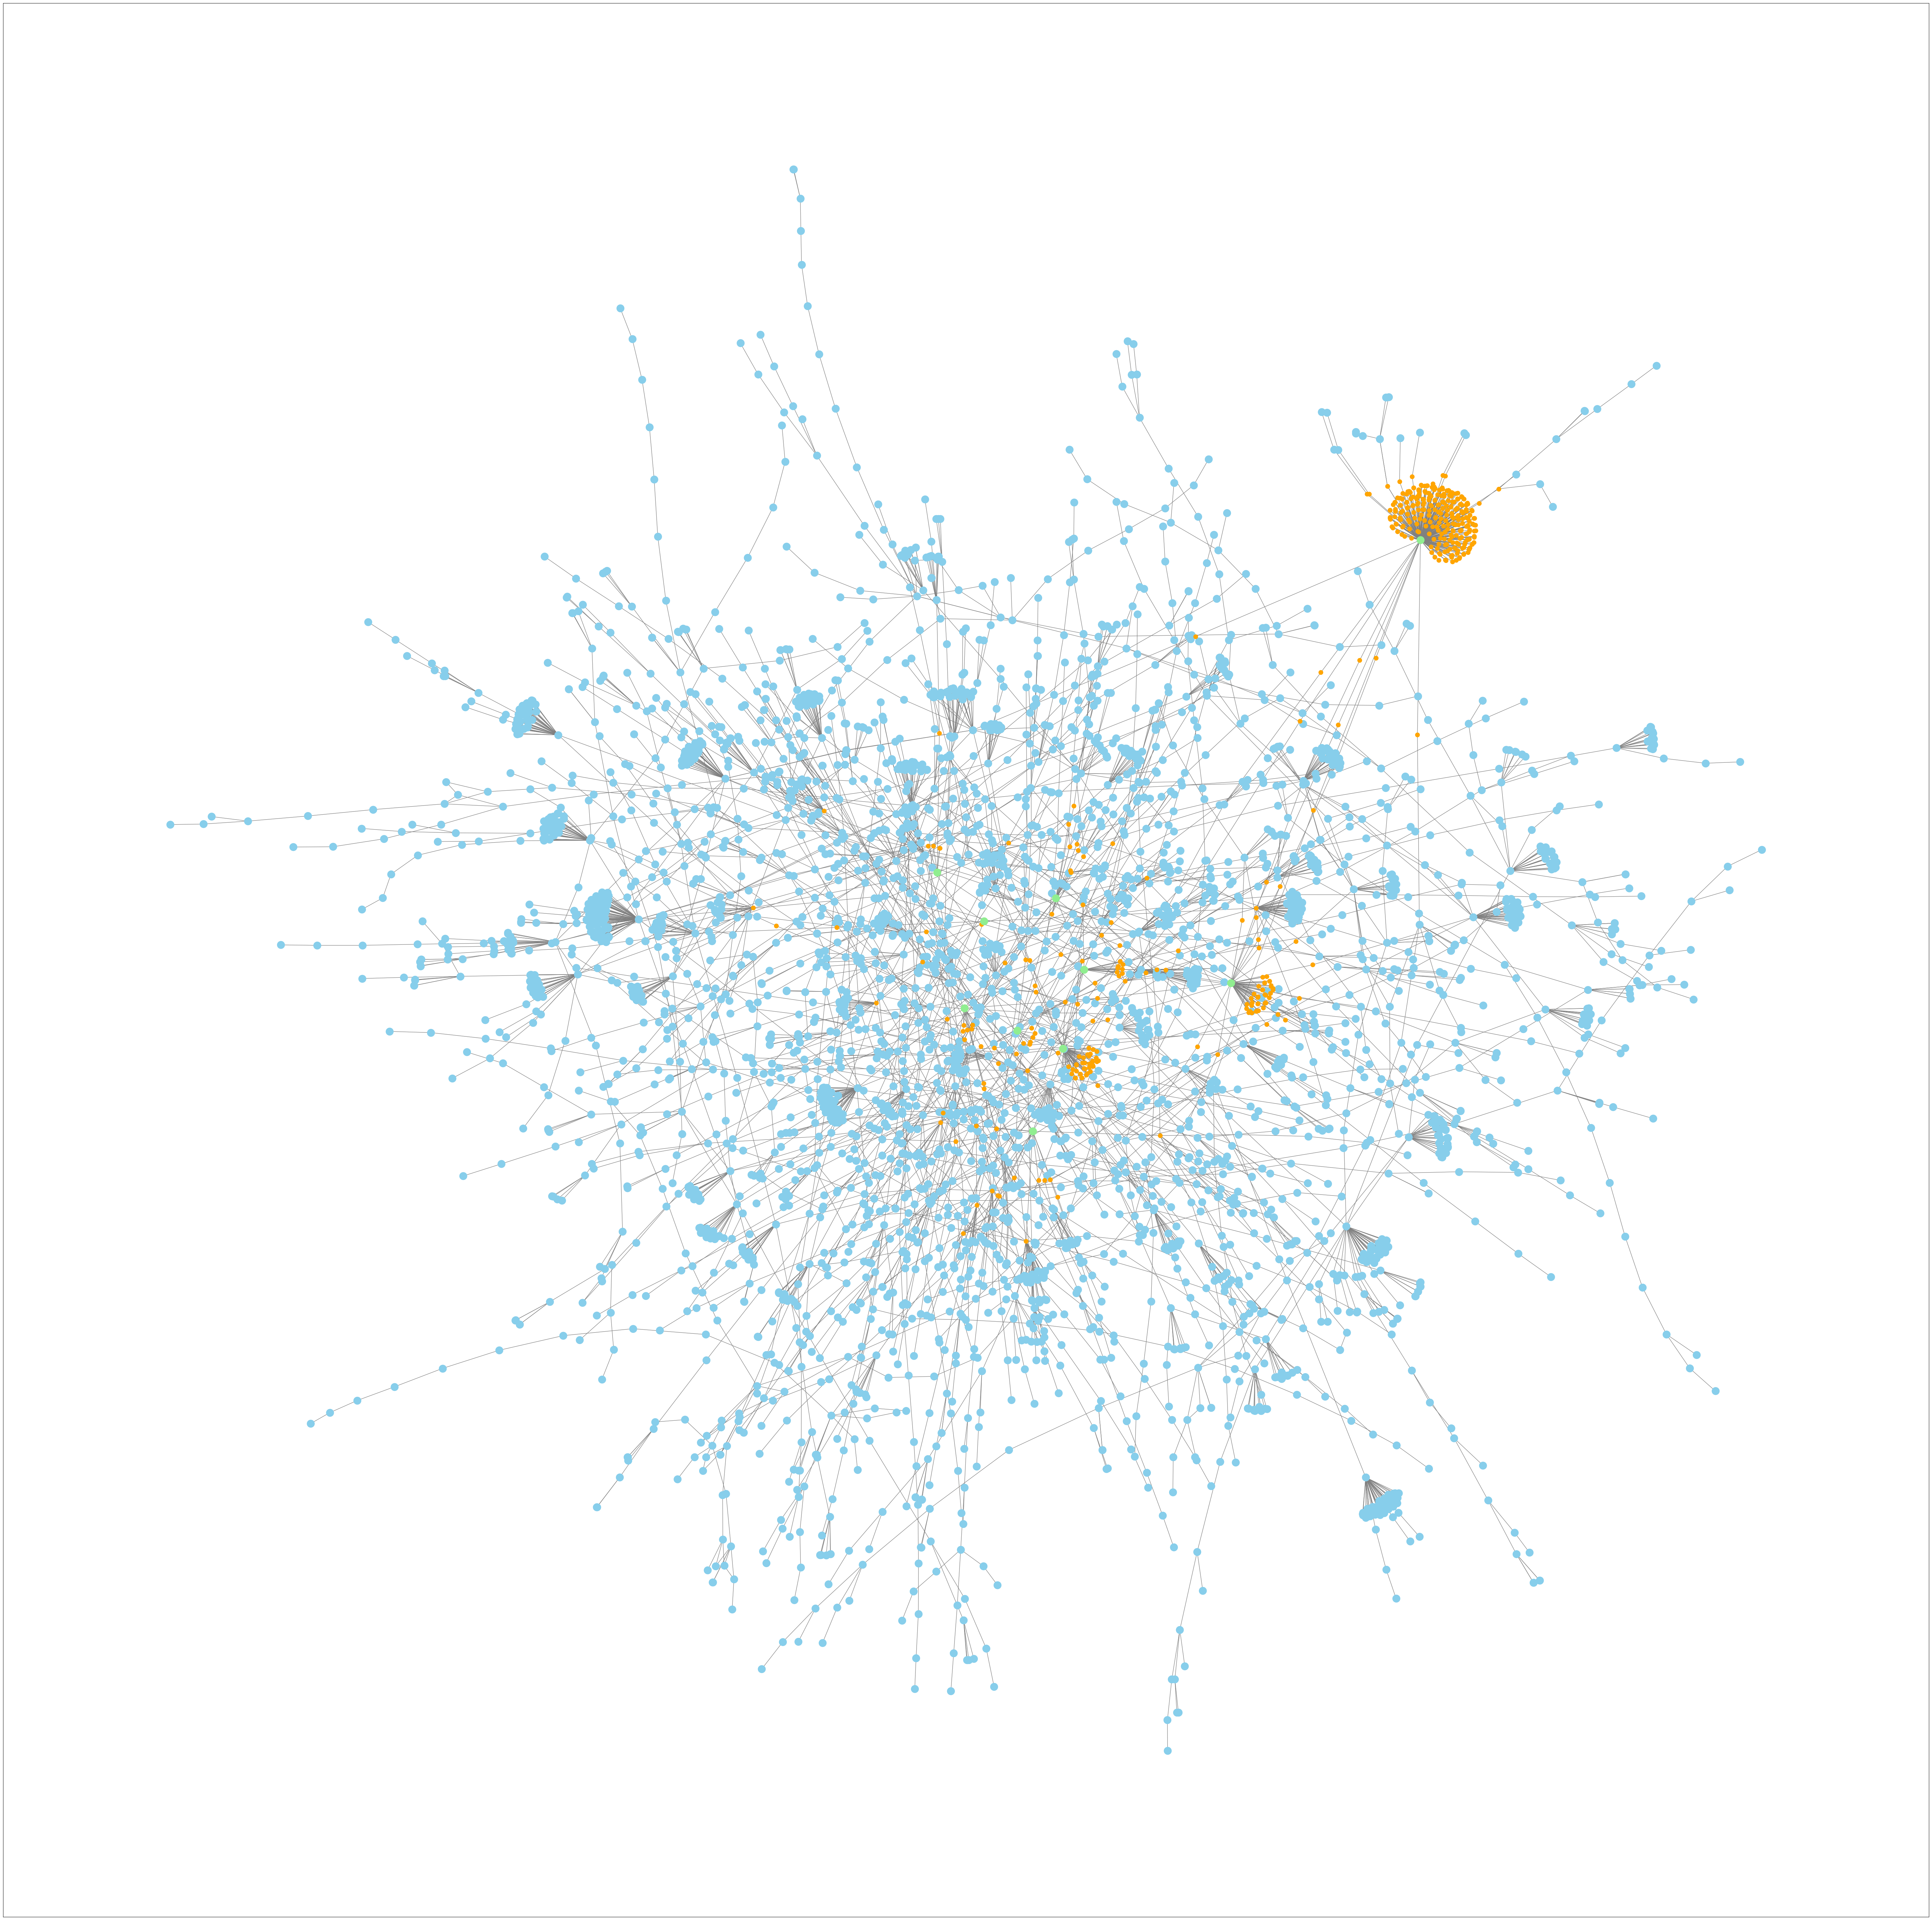

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

target_node = '4618623496493157' # node of the CAH

reachable_nodes = nx.single_source_shortest_path_length(G, target_node).keys()

G = G.subgraph(reachable_nodes)

important_nodes = ['神猫罗尼休', 'Tiger公子', '赵立坚个人微博', '夏目家的小诗哥',
                   '日本傻事', '伊谢尔伦的风', '重工组长于彦舒', '八鸡扒摁撕垃圾站',
                   'JoannaBlue', '红烧蒸猪']  # Nodes with the highest betweenness centrality

neighbor_nodes = set()
for node in important_nodes:
    neighbor_nodes.update(G.neighbors(node))
neighbor_nodes.difference_update(important_nodes)

plt.figure(figsize=(80, 80))
pos = nx.spring_layout(G)

other_nodes = set(G.nodes()) - set(important_nodes) - neighbor_nodes
nx.draw_networkx_nodes(G, pos, nodelist=list(other_nodes), node_color='skyblue', label='Other Nodes')

nx.draw_networkx_nodes(G, pos, nodelist=list(neighbor_nodes), node_color='orange', node_size=100, label='Neighbor Nodes')

nx.draw_networkx_nodes(G, pos, nodelist=important_nodes, node_color='lightgreen', node_size=300, label='Important Nodes')

nx.draw_networkx_edges(G, pos, edge_color='gray')

plt.show()
